# Full pipeline for Region-Based Classifier

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Built-in
import os
from pathlib import Path

# External
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import RocCurveDisplay, auc
from sklearn.preprocessing import StandardScaler

# Local
from adad.distance import DAIndexDelta, DAIndexGamma, DAIndexKappa
from adad.evaluate import (cumulative_accuracy, permutation_auc,
                           predictiveness_curves, roc_ad,
                           sensitivity_specificity)
from adad.utils import category2code, drop_redundant_col, maccs2binary


In [3]:
plt.rcParams["font.size"] = 16

In [4]:
# Step 1: Load data
PATH_ROOT = Path(os.getcwd()).absolute().parent
print(PATH_ROOT)

file_data = os.path.join(PATH_ROOT, "data", "maccs", "Ames_MACCS.csv")
file_idx_train = os.path.join(PATH_ROOT, "experiments", "cv_indices", "Ames_cv_train.csv")
file_idx_test = os.path.join(PATH_ROOT, "experiments", "cv_indices", "Ames_cv_test.csv")

/home/lukec/workspace/applicabilityDomain


In [5]:
idx_train = pd.read_csv(file_idx_train, dtype=pd.Int64Dtype())
idx_train.iloc[-5:]

,cv1,cv2,cv3,cv4,cv5
5523,6476,6477,6476,6489,6502
5524,6477,6479,6477,6492,6508
5525,6479,6489,6479,<NA>,<NA>
5526,6489,6492,6489,<NA>,<NA>
5527,6492,<NA>,6492,<NA>,<NA>


In [6]:
idx_test = pd.read_csv(file_idx_test, dtype=pd.Int64Dtype())
idx_test.iloc[-5:]

,cv1,cv2,cv3,cv4,cv5
982,6497,6504,6494,6471,6476
983,6498,6505,6501,6482,6477
984,<NA>,6510,<NA>,6496,6479
985,<NA>,<NA>,<NA>,6502,6489
986,<NA>,<NA>,<NA>,6508,6492


In [7]:
data = pd.read_csv(file_data)
data["y"] = data["y"].astype("category").cat.codes
print("Labels:", data["y"].unique())
print("Shape:", data.shape)
data.head()

Labels: [0 1]
Shape: (6512, 167)


,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x158,x159,x160,x161,x162,x163,x164,x165,x166,y
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,5.0,0.0,2.0,1.0,42.0,6.0,44.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,1.0,0.0,5.0,0.0,0.0,2.0,0.0,0.0,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,1.0,0.0,4.0,0.0,6.0,2.0,6.0,0.0,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,1.0,0.0,4.0,0.0,0.0,2.0,0.0,0.0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,2.0,1.0,4.0,0.0,6.0,3.0,6.0,0.0,1


In [8]:
# Only load one CV split
idx_test_cv1 = idx_test['cv1'].dropna(axis=0).to_numpy().astype(int)
idx_train_cv1 = idx_train['cv1'].dropna(axis=0).to_numpy().astype(int)
print(idx_test_cv1[:5])
print(idx_train_cv1[:5])
assert len(idx_test_cv1) + len(idx_train_cv1) == data.shape[0]

# Check if any index from test set is also in train set
assert not np.all(np.isin(idx_test_cv1, idx_train_cv1))

[ 2 11 15 17 20]
[ 8 23 25 36 39]


In [9]:
y = data['y'].to_numpy().astype(int)

# Drop columns with no information for training.
data = drop_redundant_col(data)
X = data.drop(['y'], axis=1).to_numpy()

In [10]:
# These are required for Region-Based Classifier
X = data.drop(['y'], axis=1)
# Convert values to integer categorical data
X = category2code(X).to_numpy()

In [11]:
# Change any value greater than 1 to 1
# X = maccs2binary(X)

In [12]:
X_train, X_test = X[idx_train_cv1], X[idx_test_cv1]
y_train, y_test = y[idx_train_cv1], y[idx_test_cv1]
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(5528, 154) (984, 154)
(5528,) (984,)


In [13]:
# Centred at 0.
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

In [14]:
# Step 2: Train classifier
N_TREES = 300
SEED = np.random.randint(1000, 999999)
print(SEED)
clf = RandomForestClassifier(n_estimators=N_TREES, random_state=SEED)
print(clf.get_params())
clf.fit(X_train, y_train)

acc_train = clf.score(X_train, y_train)
acc_test = clf.score(X_test, y_test)
print(f'[Accuracy] Train: {acc_train*100:.2f}%, test: {acc_test*100:.2f}%')

743404
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 300, 'n_jobs': None, 'oob_score': False, 'random_state': 743404, 'verbose': 0, 'warm_start': False}
[Accuracy] Train: 99.01%, test: 78.25%


In [15]:
# # Step 3: Train AD
# ad = DAIndexKappa(k=5, dist_metric='jaccard')
# # ad = DAIndexGamma(k=5, dist_metric='euclidean')
# # ad = DAIndexDelta(k=5, dist_metric='euclidean')
# ad.fit(X_train)

## How to choose R_MIN and R_MAX?
Set boundary to a relatively large value, run the `fit` function, and then adjust R_MIN and R_MAX based on the console outputs.

In [16]:
from adad.adversarial import SklearnRegionBasedClassifier
from adad.utils import get_range

# Parameters for Region-Based Classifier
R_MIN = 0.08
R_MAX = 0.12
STEP_SIZE = 1
EPS = 0.01

x_min, x_max = get_range(X_train)
# TODO: Add MAX_ITER as a parameter!
ad = SklearnRegionBasedClassifier(
    clf,
    sample_size=200,
    x_min=x_min,
    x_max=x_max,
    r_min=R_MIN,
    r_max=R_MAX,
    step_size=STEP_SIZE,
    eps=EPS,
    data_type='discrete',
    verbose=1)

ad.fit(X_train, y_train)

[adad.adversarial.region_based_classifier]:Point-based accuracy: 99.01%.
[adad.adversarial.region_based_classifier]:n_class: 2
[adad.adversarial.region_based_classifier]:Search Low: 0.0800 Mid: 0.1000 High: 0.1200
100%|███████████████████████████████████████████████████████████| 5528/5528 [02:01<00:00, 45.31it/s]
[adad.adversarial.region_based_classifier]:Search Low: 0.1075 Mid: 0.1137 High: 0.1200
100%|███████████████████████████████████████████████████████████| 5528/5528 [02:02<00:00, 44.96it/s]
[adad.adversarial.region_based_classifier]:Total training time: 00h04m05s
[adad.adversarial.region_based_classifier]:Best r: 0.1137


In [17]:
dm = ad.measure(X_test)
idx = int(np.round(dm.shape[0] * 0.9))

100%|█████████████████████████████████████████████████████████████| 984/984 [00:22<00:00, 44.26it/s]


In [18]:
# Step 4: Evaluate
y_pred = clf.predict(X_test)
tpr, tnr = sensitivity_specificity(y_test, y_pred)
print(f'Sensitivity: {tpr:.3f}')
print(f'Specificity: {tnr:.3f}')

Sensitivity: 0.810
Specificity: 0.743


In [19]:
# Not all DM requires to inverse the value
dm = 1. / (dm + 1e-6)

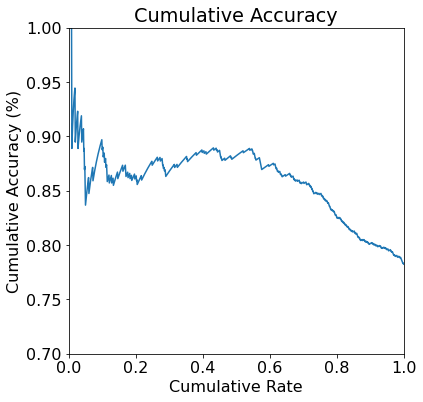

In [20]:
# TODO: `cumulative_accuracy` the order for distance measures are inverted
cumulative_acc, cumulative_rate = cumulative_accuracy(y_test, y_pred, dm)

plt.figure(figsize=(6, 6))
plt.plot(cumulative_rate, cumulative_acc)
plt.xlabel("Cumulative Rate")
plt.xlim((0, 1.0))
plt.ylabel("Cumulative Accuracy (%)")
plt.ylim((0.7, 1.0))
plt.title("Cumulative Accuracy")
plt.show()

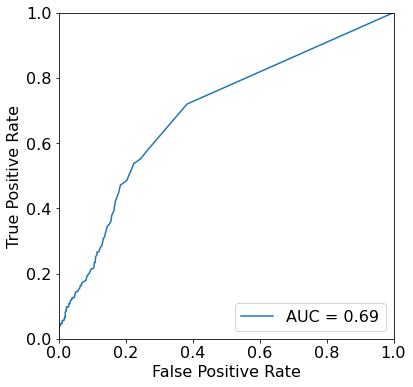

In [21]:
# TODO: `roc_ad` the order for distance measures are inverted
fpr, tpr = roc_ad(y_test, y_pred, dm)
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots(figsize=(6, 6))
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
roc_display.plot(ax=ax)
ax.set_xlim(0., 1.)
ax.set_ylim(0., 1.)
plt.show()

In [22]:
perm_auc, _ = permutation_auc(y_test, y_pred, dm)
print(perm_auc)

0.5817690496575343


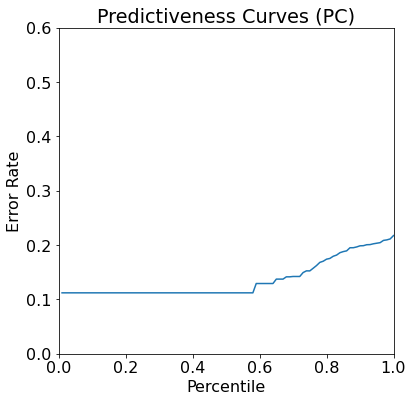

In [23]:
# TODO: `predictiveness_curves` the order for distance measures are inverted
percentile, error_rate = predictiveness_curves(y_test, y_pred, dm)

fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(percentile, error_rate)
ax.set_xlabel("Percentile")
ax.set_xlim(0., 1.)
ax.set_ylabel("Error Rate")
ax.set_ylim(0, 0.6)
ax.set_title("Predictiveness Curves (PC)")
plt.show()